# Load the Data

This front portion of the database will be using pyspark as it is something that I have been keen to explore. It is also for its label encoding feature.

In [2]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
 
# Create a SparkSession
spark = SparkSession.builder.config("spark.executor.memory", "2g").appName('test').getOrCreate()
import platform


In [3]:
df_pyspark = spark.read.option('header','true').csv('ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv',inferSchema=True)
df_pyspark.show()

+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+
|              month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|   remaining_lease|resale_price|
+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+------------------+------------+
|2017-01-01 00:00:00|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|61 years 04 months|    232000.0|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|60 years 07 months|    250000.0|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|62 years 05 months|    262000.0|
|2017-01-01 00:00:00|ANG MO 

# Prepare training data

Feature engineering to change the year and remaining lease columns

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from pyspark.sql.types import StringType
from pyspark.sql.functions import concat, col, lit
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import year
from pyspark.sql.functions import quarter

df_pyspark = df_pyspark.withColumn("remaining_lease", regexp_extract('remaining_lease', r"(\d+) years", 1))
df_pyspark = df_pyspark.withColumn("year", year(df_pyspark['month']))
df_pyspark = df_pyspark.withColumn("quarter", quarter(df_pyspark['month']))
df_pyspark = df_pyspark.withColumn("formatted_quarter",  concat('year', lit(' '), 'quarter',lit('Q')))
df_pyspark.show()

+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+----+-------+-----------------+
|              month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|year|quarter|formatted_quarter|
+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+----+-------+-----------------+
|2017-01-01 00:00:00|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|             61|    232000.0|2017|      1|          2017 1Q|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|             60|    250000.0|2017|      1|          2017 1Q|
|2017-01-01 00:00:00|ANG MO KIO|   3 ROOM|  602| A

**Handling categorical features**

In [7]:
indexer = StringIndexer(inputCols = ["town","flat_type","flat_model","storey_range","formatted_quarter"],outputCols = ["townIndexed","flatTypeIndexed","flatModelIndexed","storeyRangeIndexed","quarterIndexed"])
df_r = indexer.fit(df_pyspark).transform(df_pyspark)
df_r = df_r.withColumn("remaining_lease",df_r.remaining_lease.cast(IntegerType()))
df_r.printSchema()
df_r.show()

root
 |-- month: timestamp (nullable = true)
 |-- town: string (nullable = true)
 |-- flat_type: string (nullable = true)
 |-- block: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- storey_range: string (nullable = true)
 |-- floor_area_sqm: double (nullable = true)
 |-- flat_model: string (nullable = true)
 |-- lease_commence_date: integer (nullable = true)
 |-- remaining_lease: integer (nullable = true)
 |-- resale_price: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- formatted_quarter: string (nullable = true)
 |-- townIndexed: double (nullable = false)
 |-- flatTypeIndexed: double (nullable = false)
 |-- flatModelIndexed: double (nullable = false)
 |-- storeyRangeIndexed: double (nullable = false)
 |-- quarterIndexed: double (nullable = false)

+-------------------+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+-----------

In [8]:
from pyspark.ml.feature import VectorAssembler
feature_assembler = VectorAssembler(inputCols=['townIndexed','flatTypeIndexed','flatModelIndexed','floor_area_sqm', 'storeyRangeIndexed','remaining_lease', 'quarterIndexed'],outputCol='independent_features')
output = feature_assembler.transform(df_r)

## Supplementary Data

Map the travel and walk time to the corresponding street name

In [9]:
location_data_df = spark.read.csv("travel_times.csv", header=True)
location_dict_travelTime = dict(location_data_df.rdd.map(lambda row: (row["0"], row['travel_time'])).collect())

from pyspark.sql.functions import col, expr

def map_travel_time(street_name):
    return location_dict_travelTime.get(street_name, None)

# Register the UDF
spark.udf.register("map_travel_time", map_travel_time)

# Use the UDF to create a new column "travelTime"
df_r = df_r.withColumn("travelTime", expr("map_travel_time(street_name)"))

location_dict_walkTime = dict(location_data_df.rdd.map(lambda row: (row["0"], row['walk_time'])).collect())

from pyspark.sql.functions import col, expr

def map_walk_time(street_name):
    return location_dict_walkTime.get(street_name, None)

# Register the UDF
spark.udf.register("map_walk_time", map_walk_time)

# Use the UDF to create a new column "travelTime"
df_r = df_r.withColumn("walkTime", expr("map_walk_time(street_name)"))

df_r = df_r.withColumn("walkTime",df_r.walkTime.cast(DoubleType()))
df_r = df_r.withColumn("travelTime",df_r.travelTime.cast(DoubleType()))

## BASE MODELS

In [31]:
all_features = ['townIndexed','flatModelIndexed','floor_area_sqm', 'storeyRangeIndexed','remaining_lease', 'resale_price','walkTime','travelTime','quarterIndexed']
independent_features = ['townIndexed','flatModelIndexed','floor_area_sqm', 'storeyRangeIndexed','remaining_lease','walkTime','travelTime','quarterIndexed']

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

base_df, val_df = df_r.select(all_features).randomSplit([0.7, 0.3], seed = 88)

base_df = base_df.toPandas()
val_df = val_df.toPandas()

scaler = MinMaxScaler()

# Training and testing data
X = base_df[independent_features]
y = base_df["resale_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.29, random_state = 0)

### **LightGBM: lgb_reg**

In [34]:
import lightgbm as lgb

In [35]:
# Hyperparameter tuning
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'num_leaves': [20, 30, 40, 50, 60],
#     'learning_rate': [0.05, 0.1, 0.2, 0.25, 0.3],
#     'n_estimators': [50, 100, 200, 230, 250]
# }
# lgb_reg = lgb.LGBMRegressor()
# grid_search = GridSearchCV(lgb_reg, param_grid, scoring='neg_mean_squared_error', cv=3)
# grid_search.fit(X_train, y_train)

# # Get the best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Print the best parameters
# print("Best Parameters:", best_params)

# # Print the best model
# print("\nBest Model:")
# print(best_model)

In [36]:
lgb_reg = lgb.LGBMRegressor(learning_rate=0.25, n_estimators=300, num_leaves=60)
lgb_reg.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 79866, number of used features: 8
[LightGBM] [Info] Start training from score 485074.371048


LGBMRegressor(learning_rate=0.25, n_estimators=300, num_leaves=60)

Root Mean Squared Error (RMSE): 28704.576738396634
0.9710393534984975


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

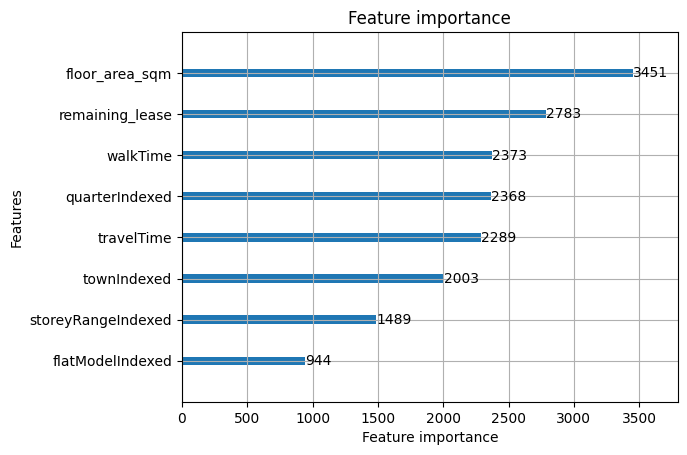

In [37]:
# Accuracy
from sklearn.metrics import mean_squared_error
from lightgbm import plot_importance

y_pred_lgb = lgb_reg.predict(X_test)
rmse=mean_squared_error(y_pred_lgb, y_test, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(lgb_reg.score(X_test, y_test))
plot_importance(lgb_reg)

### **Random Forests: rf_reg**

In [38]:
from sklearn.ensemble import RandomForestRegressor


In [39]:
# param_grid = {
#     'n_estimators': [50, 100, 200,300,350],
#     'max_depth': [3, 5, 10,15,20],
#     'min_samples_split': [2, 5, 10,15,20]
# }

# # Initialize the Random Forest Regressor
# rf_regressor = RandomForestRegressor(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(rf_regressor, param_grid, scoring='neg_mean_squared_error', cv=3)

# # Fit the GridSearchCV to the data
# grid_search.fit(X, y)

# # Get the best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Print the best parameters
# print("Best Parameters:", best_params)

# # Print the best model
# print("\nBest Model:")
# print(best_model)

Best Parameters: {'max_depth': 20, 'min_samples_split': 15, 'n_estimators': 300}

Best Model:
RandomForestRegressor(max_depth=20, min_samples_split=15, n_estimators=300,
                      random_state=42)

In [40]:
rf_reg = RandomForestRegressor(max_depth=20, min_samples_split=15, n_estimators=300, max_leaf_nodes= 3000)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_leaf_nodes=3000, min_samples_split=15,
                      n_estimators=300)

In [41]:
y_pred_rf = rf_reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
print(f"Mean Squared Error (MSE): {rmse}")
rf_reg.score(X_test, y_test)

Mean Squared Error (MSE): 40052.79505165723


0.9436139574755625

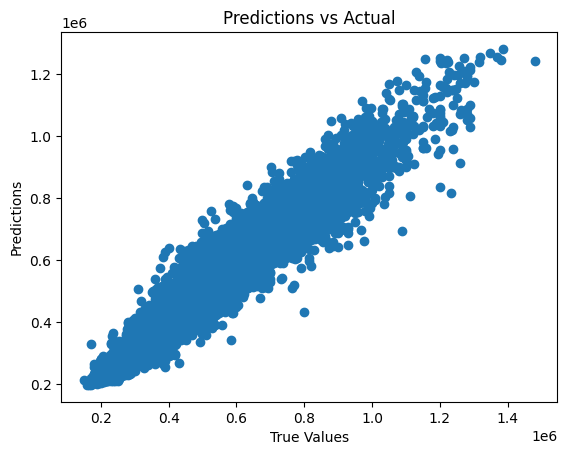

In [42]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_rf)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual')
plt.show()

### **Multiple Regression**

In [43]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Creating a linear regression model
mult_reg = LinearRegression()

# Training the model with the data
mult_reg.fit(X_train, y_train)

# Printing the coefficients and intercept
print("Coefficients:", mult_reg.coef_)
print("Intercept:", mult_reg.intercept_)
print(mult_reg.score(X_test, y_test))

Coefficients: [ 7642.88863142  9384.01062117  3941.98542703 16275.68933978
  3827.44795419    91.77063991   -82.98065987 -3008.50993261]
Intercept: -252330.69042982487
0.6128578128102367
